In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils

In [2]:
# Load data and preprocess images (as you provided)
labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
X = []
y = []

image_size = 224

for i in labels:
    folderPath = os.path.join('Tumor1/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

X = np.array(X)
y = np.array(y)

100%|████████████████████████████████████████| 793/793 [00:00<00:00, 874.28it/s]


In [3]:
# Perform label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [4]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.10, random_state=42)

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [6]:
from tensorflow.keras.utils import to_categorical
# Convert integer labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train, num_classes=len(labels))
y_val_onehot = to_categorical(y_val, num_classes=len(labels))

In [9]:
# Define the CNN model
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
# model_cnn.add(Dropout(0.5))

model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(512, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(len(labels), activation='softmax'))  # Output layer

# Print model summary
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

In [10]:
#compile model
model_cnn.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

batch_size = 32
epochs = 30

#train the model
history = model_cnn.fit(datagen.flow(X_train, y_train_onehot, batch_size=batch_size),
    validation_data=(X_val, y_val_onehot),
    epochs=epochs,verbose=1,callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/30


2023-08-29 21:22:48.451602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


207/207 [==============================] - ETA: 0s - loss: 1.7973 - accuracy: 0.3761

2023-08-29 21:23:17.322555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.47554, saving model to model.h5
207/207 [==============================] - 30s 140ms/step - loss: 1.7973 - accuracy: 0.3761 - val_loss: 1.2446 - val_accuracy: 0.4755 - lr: 0.0010
Epoch 2/30
207/207 [==============================] - ETA: 0s - loss: 0.9870 - accuracy: 0.6218
Epoch 2: val_accuracy improved from 0.47554 to 0.68750, saving model to model.h5
207/207 [==============================] - 29s 139ms/step - loss: 0.9870 - accuracy: 0.6218 - val_loss: 0.8811 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/30
207/207 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.7528
Epoch 3: val_accuracy improved from 0.68750 to 0.83560, saving model to model.h5
207/207 [==============================] - 29s 139ms/step - loss: 0.7124 - accuracy: 0.7528 - val_loss: 0.4570 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 4/30
207/207 [==============================] - ETA: 0s - loss: 0.5593 - accuracy: 0.8057
Epoch 4: val_accuracy improved

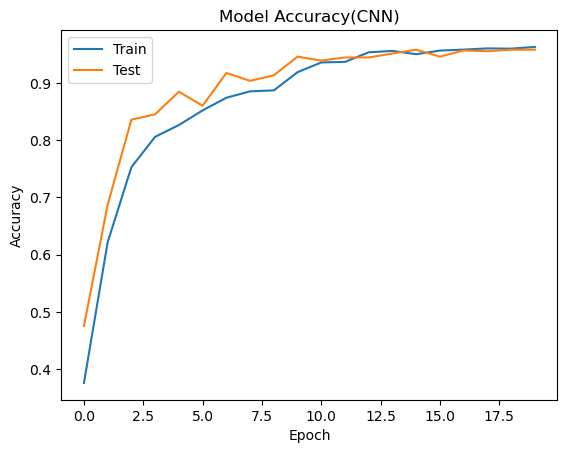

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy(CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

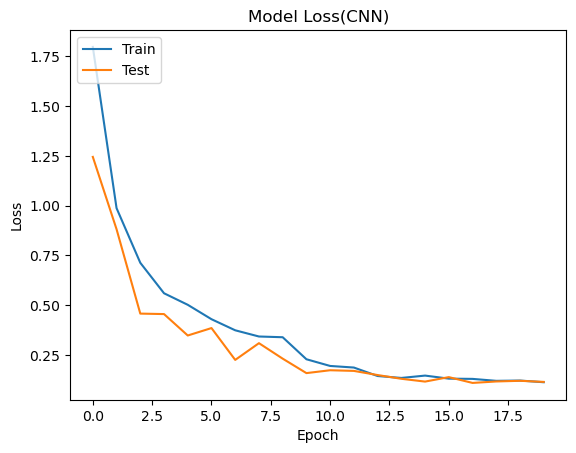

In [13]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss(CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
# Save the trained model in SavedModel format
from tensorflow.keras.models import load_model, save_model
model_cnn.save('CNNFinal.h5')
model = load_model('CNNFinal.h5')

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train_onehot)
print(f"Training Loss: {loss:.4f}, Training Accuracy: {accuracy:.4f}")

  1/207 [..............................] - ETA: 35s - loss: 0.0209 - accuracy: 1.0000

2023-08-29 21:33:47.330520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


207/207 [==============================] - 5s 22ms/step - loss: 0.0818 - accuracy: 0.9699
Training Loss: 0.0818, Training Accuracy: 0.9699


In [17]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val_onehot)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

23/23 [==============================] - 1s 22ms/step - loss: 0.1138 - accuracy: 0.9579
Validation Loss: 0.1138, Validation Accuracy: 0.9579


In [18]:
# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val_onehot, axis=1)

 5/23 [=====>........................] - ETA: 0s

2023-08-29 21:34:04.696952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 22ms/step


In [19]:
# Generate classification report and confusion matrix
print(classification_report(y_val_labels, y_pred_labels, target_names=labels))
confusion = confusion_matrix(y_val_labels, y_pred_labels)
print("Confusion Matrix:\n", confusion)

              precision    recall  f1-score   support

      glioma       0.95      0.95      0.95       128
  meningioma       0.95      0.86      0.90       146
 neurocytoma       1.00      0.98      0.99        85
     notumor       0.97      1.00      0.98       144
   pituitary       0.93      0.99      0.96       141
  schwannoma       0.98      1.00      0.99        92

    accuracy                           0.96       736
   macro avg       0.96      0.96      0.96       736
weighted avg       0.96      0.96      0.96       736

Confusion Matrix:
 [[122   5   0   0   1   0]
 [  7 125   0   3  10   1]
 [  0   0  83   2   0   0]
 [  0   0   0 144   0   0]
 [  0   1   0   0 139   1]
 [  0   0   0   0   0  92]]


In [20]:
from keras.utils import to_categorical
# Load and preprocess test images
test_folder = 'Tumor1/Testing'  # Update with your test image directory
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = ...  # Set your desired image size
num_classes = len(test_labels)

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (224, 224))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

 4/50 [=>............................] - ETA: 1s

2023-08-29 21:34:35.688668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 23ms/step - loss: 0.1650 - accuracy: 0.9423
Test Loss: 0.1650, Test Accuracy: 0.9423
              precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       300
  meningioma       0.91      0.87      0.89       306
 neurocytoma       0.96      0.95      0.96       153
     notumor       0.94      0.98      0.96       405
   pituitary       0.93      0.99      0.96       300
  schwannoma       0.92      0.99      0.96       130

    accuracy                           0.94      1594
   macro avg       0.94      0.95      0.94      1594
weighted avg       0.94      0.94      0.94      1594

[[269  20   0   2   9   0]
 [  3 266   1  17  12   7]
 [  0   0 146   6   0   1]
 [  0   2   5 395   0   3]
 [  1   2   0   0 297   0]
 [  0   1   0   0   0 129]]


2023-08-29 21:51:43.102154: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-08-29 21:51:43.102175: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-29 21:51:43.102184: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-29 21:51:43.102209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-29 21:51:43.102221: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/1 [==============================] - 0s 76ms/step


2023-08-29 21:51:43.439900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


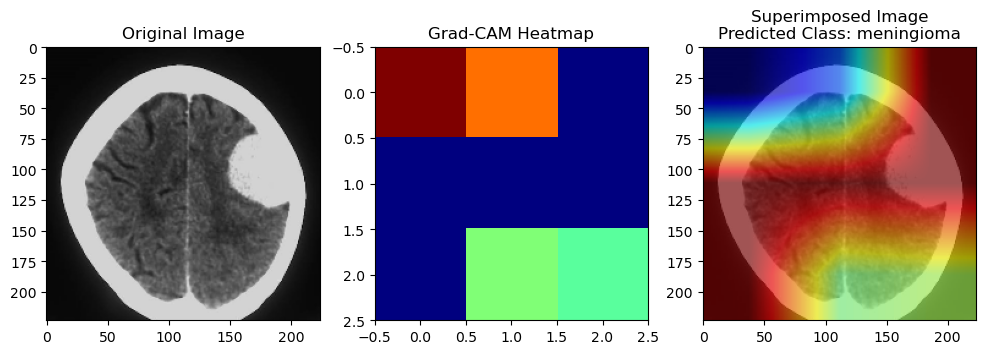

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

def get_gradcam(image, model, class_idx, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def superimpose_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

def visualize_gradcam(image_path, model, labels, target_layer_name):
    image_size = (224, 224)
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load the image.")
        return
    image = cv2.resize(image, image_size)
    image = np.expand_dims(image, axis=0)
    
    # Predict the class of the image
    class_predictions = model.predict(image)
    predicted_class_idx = np.argmax(class_predictions)
    predicted_class_name = labels[predicted_class_idx]
    
    # Generate Grad-CAM
    heatmap = get_gradcam(image, model, predicted_class_idx, target_layer_name)
    
    # Superimpose heatmap on the original image
    superimposed_image = superimpose_image(image[0], heatmap)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.imshow(image[0])
    plt.title('Original Image')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.subplot(133)
    plt.imshow(superimposed_image)
    plt.title('Superimposed Image\nPredicted Class: {}'.format(predicted_class_name))
    plt.show()

def main():
    # Define labels and other parameters
    labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
    target_layer_name = 'conv2d_11'
    
    # Path to the specific image
    specific_image_path = 'Tumor1/Testing/meningioma/Te-meTr_0009.jpg'
    
    # Load your model
    model = tf.keras.models.load_model('CNNFinal.h5')
    
    # Visualize Grad-CAM
    visualize_gradcam(specific_image_path, model, labels, target_layer_name)

if __name__ == "__main__":
    main()


2023-08-29 21:51:51.676845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


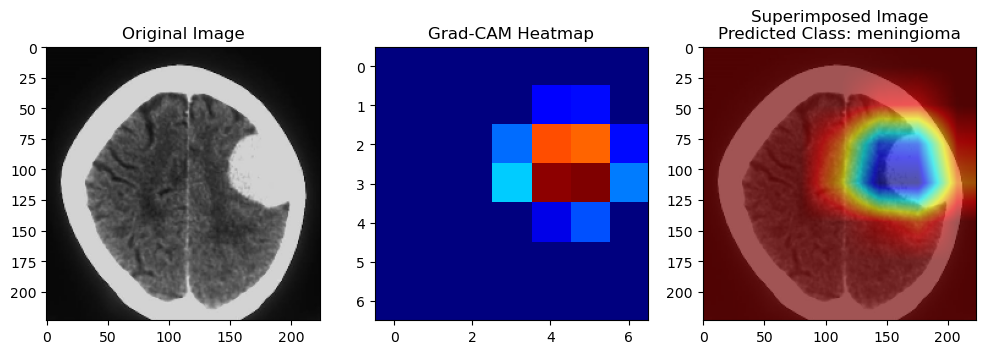

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

def get_gradcam(image, model, class_idx, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def superimpose_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

def visualize_gradcam(image_path, model, labels, target_layer_name):
    image_size = (224, 224)
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load the image.")
        return
    image = cv2.resize(image, image_size)
    image = np.expand_dims(image, axis=0)
    
    # Predict the class of the image
    class_predictions = model.predict(image)
    predicted_class_idx = np.argmax(class_predictions)
    predicted_class_name = labels[predicted_class_idx]
    
    # Generate Grad-CAM
    heatmap = get_gradcam(image, model, predicted_class_idx, target_layer_name)
    
    # Superimpose heatmap on the original image
    superimposed_image = superimpose_image(image[0], heatmap)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.imshow(image[0])
    plt.title('Original Image')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.subplot(133)
    plt.imshow(superimposed_image)
    plt.title('Superimposed Image\nPredicted Class: {}'.format(predicted_class_name))
    plt.show()

def main():
    # Define labels and other parameters
    labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
    target_layer_name = 'top_conv'
    
    # Path to the specific image
    specific_image_path = 'Tumor1/Testing/meningioma/Te-meTr_0009.jpg'
    
    # Load your model
    model = tf.keras.models.load_model('effmodel.h5')
    
    # Visualize Grad-CAM
    visualize_gradcam(specific_image_path, model, labels, target_layer_name)

if __name__ == "__main__":
    main()


2023-08-29 21:51:59.637972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 405ms/step


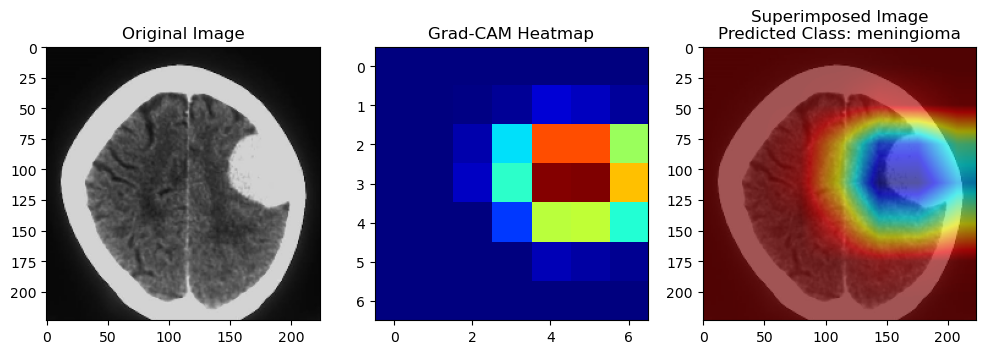

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

def get_gradcam(image, model, class_idx, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def superimpose_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

def visualize_gradcam(image_path, model, labels, target_layer_name):
    image_size = (224, 224)
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load the image.")
        return
    image = cv2.resize(image, image_size)
    image = np.expand_dims(image, axis=0)
    
    # Predict the class of the image
    class_predictions = model.predict(image)
    predicted_class_idx = np.argmax(class_predictions)
    predicted_class_name = labels[predicted_class_idx]
    
    # Generate Grad-CAM
    heatmap = get_gradcam(image, model, predicted_class_idx, target_layer_name)
    
    # Superimpose heatmap on the original image
    superimposed_image = superimpose_image(image[0], heatmap)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.imshow(image[0])
    plt.title('Original Image')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.subplot(133)
    plt.imshow(superimposed_image)
    plt.title('Superimposed Image\nPredicted Class: {}'.format(predicted_class_name))
    plt.show()

def main():
    # Define labels and other parameters
    labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
    target_layer_name = 'block14_sepconv2_act'
    
    # Path to the specific image
    specific_image_path = 'Tumor1/Testing/meningioma/Te-meTr_0009.jpg'
    
    # Load your model
    model = tf.keras.models.load_model('Xception(99%).h5')
    
    # Visualize Grad-CAM
    visualize_gradcam(specific_image_path, model, labels, target_layer_name)

if __name__ == "__main__":
    main()


In [4]:
import io
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import FileUpload, Button, Output, VBox
from IPython.display import display, clear_output
from tensorflow.keras.models import load_model, Model

# Constants
SPECIFIC_TARGET_LAYER_NAME = 'conv2d_11'  # Fill in the correct layer name
LABELS = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']  # List of class labels

def get_gradcam(image, model, class_idx, layer_name):
    # Get the output tensor of the specific layer
    layer_output = model.get_layer(layer_name).output

    # Create a model that outputs the layer's activations and the model's predictions
    grad_model = Model(inputs=model.input, outputs=[layer_output, model.output])

    # Calculate the gradient of the predicted class with respect to the output feature map
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def superimpose_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

def visualize_images(original_img, heatmap, superimposed_img, predicted_class_name):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(131)
    plt.imshow(original_img)
    plt.title('Original Image')
    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    
    plt.subplot(133)
    plt.imshow(superimposed_img)
    plt.title(f'Superimposed Image\nPredicted Class: {predicted_class_name}')
    
    plt.tight_layout()
    plt.show()

def process_uploaded_images(upload):
    for file_info in upload:
        img = Image.open(io.BytesIO(file_info['content']))
        opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = cv2.resize(opencvImage, (224, 224))
        img = img.reshape(1, 224, 224, 3)

        # Predict the class of the image
        p = model.predict(img)
        p = np.argmax(p, axis=1)[0]
        predicted_class_name = LABELS[p]

        # Generate Grad-CAM
        heatmap = get_gradcam(img, model, p, SPECIFIC_TARGET_LAYER_NAME)
        superimposed_image = superimpose_image(img[0], heatmap)

        # Display the original image, Grad-CAM heatmap, and superimposed image
        with out:
            clear_output(wait=True)
            visualize_images(img[0], heatmap, superimposed_image, predicted_class_name)

def on_button_clicked(_):
    with out:
        clear_output(wait=True)
        if uploader.value:
            process_uploaded_images(uploader.value)
        else:
            print('No Image Uploaded')

# Load the trained model
model = load_model('CNNFinal.h5')  # Replace with the correct path to your model file

# Create the widgets
uploader = FileUpload()
button = Button(description='Predict and Visualize')
out = Output()

# Link the button click event to the function
button.on_click(on_button_clicked)

# Display the widgets
widgets_box = VBox([uploader, button, out])
display(widgets_box)


In [2]:
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.models import Model
model = load_model('CNNFinal.h5')

2023-08-30 23:42:12.714513: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-08-30 23:42:12.714532: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-30 23:42:12.714538: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-30 23:42:12.714595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-30 23:42:12.714824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

 5/50 [==>...........................] - ETA: 1s

2023-08-31 23:31:22.418460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/50 [=>............................] - ETA: 1s - loss: 0.2406 - accuracy: 0.8828

2023-08-31 23:31:23.820965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 23ms/step - loss: 0.1650 - accuracy: 0.9423
Test Loss: 0.1650, Test Accuracy: 0.9423
              precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       300
  meningioma       0.91      0.87      0.89       306
 neurocytoma       0.96      0.95      0.96       153
     notumor       0.94      0.98      0.96       405
   pituitary       0.93      0.99      0.96       300
  schwannoma       0.92      0.99      0.96       130

    accuracy                           0.94      1594
   macro avg       0.94      0.95      0.94      1594
weighted avg       0.94      0.94      0.94      1594

[[269  20   0   2   9   0]
 [  3 266   1  17  12   7]
 [  0   0 146   6   0   1]
 [  0   2   5 395   0   3]
 [  1   2   0   0 297   0]
 [  0   1   0   0   0 129]]
50/50 [==============================] - 1s 19ms/step


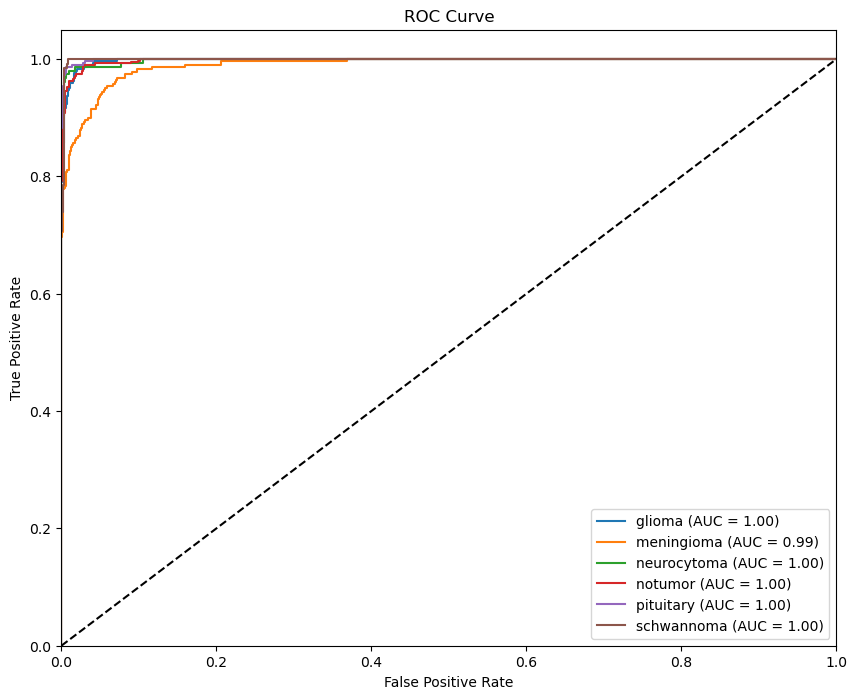

In [6]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, roc_auc_score

# Load the trained model
model = load_model('CNNFinal.h5')

# Define test labels and image size
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = (224, 224)
num_classes = len(test_labels)

# Load and preprocess test images
test_folder = '/Users/abi/Desktop/Final/Tumor1/Testing'  # Update with your test image directory

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, image_size)
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Fit the LabelEncoder on the test labels before transforming
label_encoder = LabelEncoder()
label_encoder.fit(test_labels)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

# Get the predicted probabilities for each class
y_pred_prob_test = model.predict(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    roc_auc = roc_auc_score(y_test_encoded[:, i], y_pred_prob_test[:, i])
    fpr, tpr, _ = roc_curve(y_test_encoded[:, i], y_pred_prob_test[:, i])
    plt.plot(fpr, tpr, label=f'{test_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


2023-09-01 05:06:18.933223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 9s 111ms/step


2023-09-01 05:06:28.600275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 7s 108ms/step - loss: 0.0153 - accuracy: 0.9969
Test Loss: 0.0153, Test Accuracy: 0.9969
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      1.00      0.99       306
 neurocytoma       1.00      1.00      1.00       153
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300
  schwannoma       1.00      1.00      1.00       130

    accuracy                           1.00      1594
   macro avg       1.00      1.00      1.00      1594
weighted avg       1.00      1.00      1.00      1594

[[297   2   0   0   1   0]
 [  0 305   0   0   1   0]
 [  0   0 153   0   0   0]
 [  0   0   0 405   0   0]
 [  0   1   0   0 299   0]
 [  0   0   0   0   0 130]]
50/50 [==============================] - 5s 95ms/step


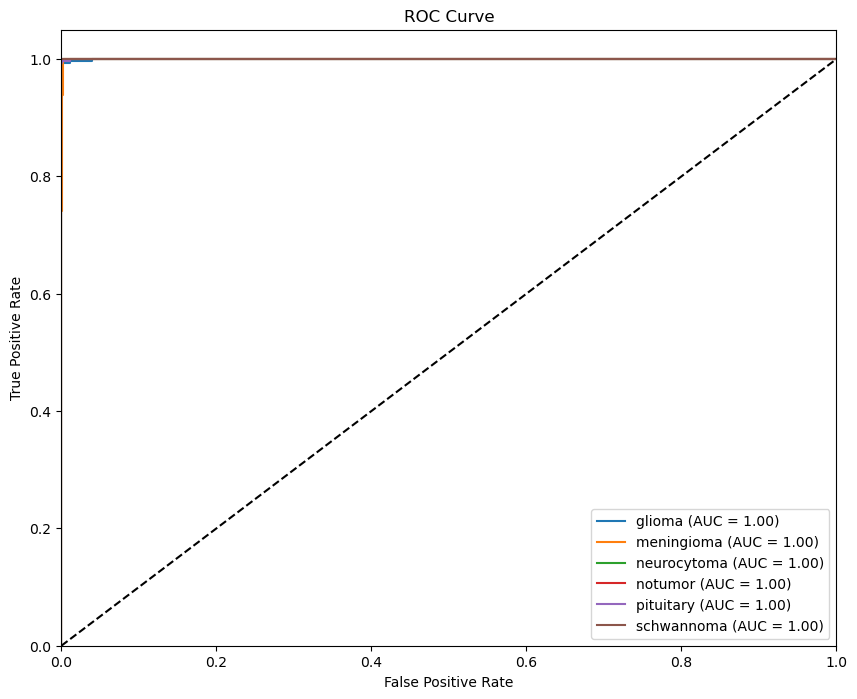

In [9]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, roc_auc_score

# Load the trained model
model = load_model('/Users/abi/Desktop/Final/Multi Class/EfficientNet/effmodel.h5')

# Define test labels and image size
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = (224, 224)
num_classes = len(test_labels)

# Load and preprocess test images
test_folder = '/Users/abi/Desktop/Final/Tumor1/Testing'  # Update with your test image directory

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, image_size)
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Fit the LabelEncoder on the test labels before transforming
label_encoder = LabelEncoder()
label_encoder.fit(test_labels)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

# Get the predicted probabilities for each class
y_pred_prob_test = model.predict(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    roc_auc = roc_auc_score(y_test_encoded[:, i], y_pred_prob_test[:, i])
    fpr, tpr, _ = roc_curve(y_test_encoded[:, i], y_pred_prob_test[:, i])
    plt.plot(fpr, tpr, label=f'{test_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


2023-09-01 05:08:45.245433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 10s 171ms/step


2023-09-01 05:08:55.074461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 9s 177ms/step - loss: 0.0139 - accuracy: 0.9950
Test Loss: 0.0139, Test Accuracy: 0.9950
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
 neurocytoma       1.00      1.00      1.00       153
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300
  schwannoma       0.98      1.00      0.99       130

    accuracy                           0.99      1594
   macro avg       0.99      1.00      0.99      1594
weighted avg       0.99      0.99      0.99      1594

[[298   2   0   0   0   0]
 [  0 302   0   1   1   2]
 [  0   0 153   0   0   0]
 [  0   0   0 405   0   0]
 [  1   1   0   0 298   0]
 [  0   0   0   0   0 130]]
50/50 [==============================] - 8s 164ms/step


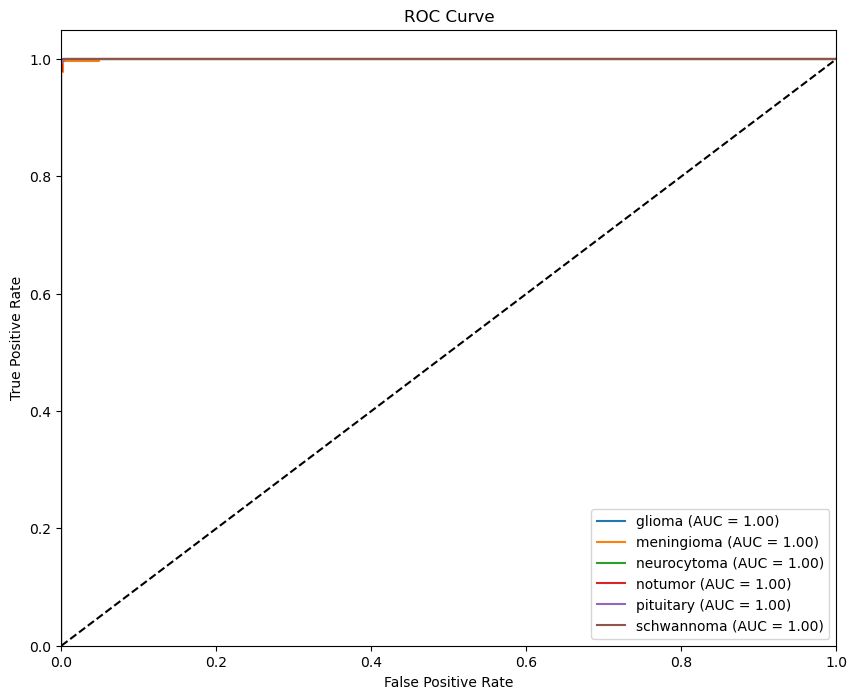

In [10]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, roc_auc_score

# Load the trained model
model = load_model('/Users/abi/Desktop/Final/Multi Class/Xception/Xception(99%).h5')

# Define test labels and image size
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = (224, 224)
num_classes = len(test_labels)

# Load and preprocess test images
test_folder = '/Users/abi/Desktop/Final/Tumor1/Testing'  # Update with your test image directory

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, image_size)
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Fit the LabelEncoder on the test labels before transforming
label_encoder = LabelEncoder()
label_encoder.fit(test_labels)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

# Get the predicted probabilities for each class
y_pred_prob_test = model.predict(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    roc_auc = roc_auc_score(y_test_encoded[:, i], y_pred_prob_test[:, i])
    fpr, tpr, _ = roc_curve(y_test_encoded[:, i], y_pred_prob_test[:, i])
    plt.plot(fpr, tpr, label=f'{test_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


2023-09-01 05:10:19.132868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 14s 195ms/step


2023-09-01 05:10:33.081930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 14s 226ms/step - loss: 0.0231 - accuracy: 0.9956
Test Loss: 0.0231, Test Accuracy: 0.9956
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
 neurocytoma       1.00      1.00      1.00       153
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300
  schwannoma       1.00      1.00      1.00       130

    accuracy                           1.00      1594
   macro avg       1.00      1.00      1.00      1594
weighted avg       1.00      1.00      1.00      1594

[[297   1   0   0   2   0]
 [  1 303   0   1   1   0]
 [  0   0 153   0   0   0]
 [  0   0   0 405   0   0]
 [  0   1   0   0 299   0]
 [  0   0   0   0   0 130]]
50/50 [==============================] - 8s 165ms/step


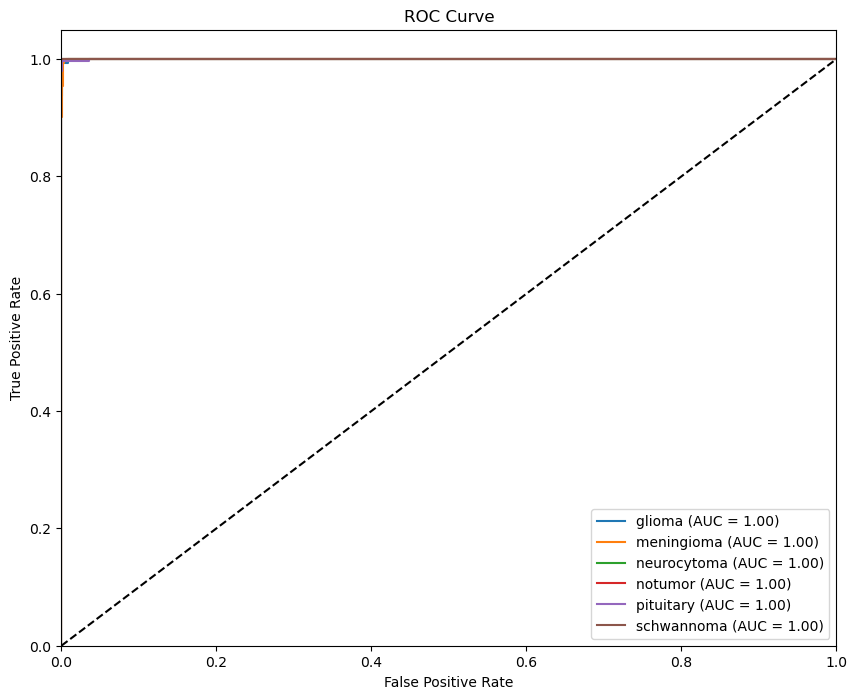

In [11]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, roc_auc_score

# Load the trained model
model = load_model('/Users/abi/Desktop/Final/Multi Class/InceptionResNetV2/Inception(98%).h5')

# Define test labels and image size
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = (224, 224)
num_classes = len(test_labels)

# Load and preprocess test images
test_folder = '/Users/abi/Desktop/Final/Tumor1/Testing'  # Update with your test image directory

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, image_size)
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Fit the LabelEncoder on the test labels before transforming
label_encoder = LabelEncoder()
label_encoder.fit(test_labels)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

# Get the predicted probabilities for each class
y_pred_prob_test = model.predict(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    roc_auc = roc_auc_score(y_test_encoded[:, i], y_pred_prob_test[:, i])
    fpr, tpr, _ = roc_curve(y_test_encoded[:, i], y_pred_prob_test[:, i])
    plt.plot(fpr, tpr, label=f'{test_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


 5/50 [==>...........................] - ETA: 1s

2023-09-01 05:58:15.919101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 7/50 [===>..........................] - ETA: 0s - loss: 0.1688 - accuracy: 0.9196

2023-09-01 05:58:17.258694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 22ms/step - loss: 0.1650 - accuracy: 0.9423
Test Loss: 0.1650, Test Accuracy: 0.9423
              precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       300
  meningioma       0.91      0.87      0.89       306
 neurocytoma       0.96      0.95      0.96       153
     notumor       0.94      0.98      0.96       405
   pituitary       0.93      0.99      0.96       300
  schwannoma       0.92      0.99      0.96       130

    accuracy                           0.94      1594
   macro avg       0.94      0.95      0.94      1594
weighted avg       0.94      0.94      0.94      1594

[[269  20   0   2   9   0]
 [  3 266   1  17  12   7]
 [  0   0 146   6   0   1]
 [  0   2   5 395   0   3]
 [  1   2   0   0 297   0]
 [  0   1   0   0   0 129]]


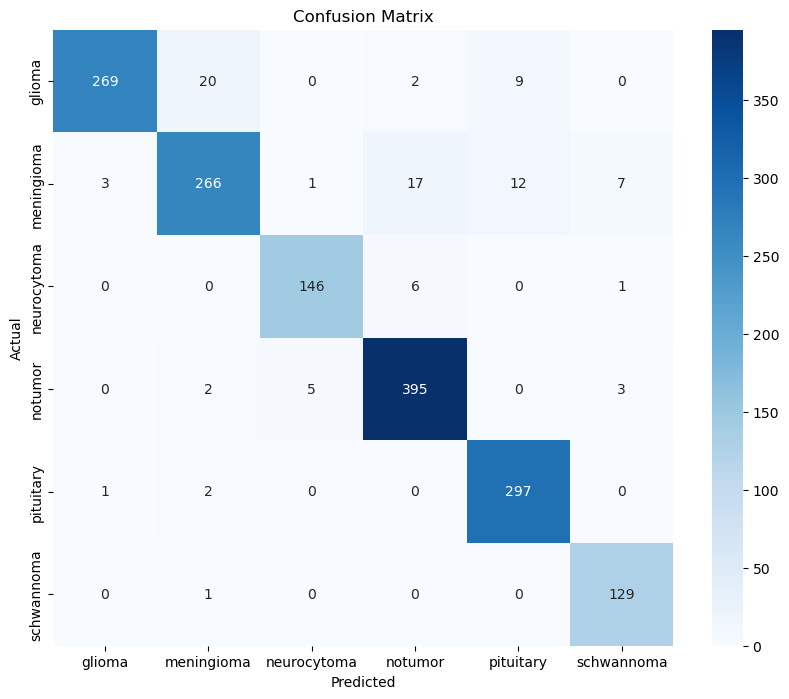

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model, save_model
model = load_model('CNNFinal.h5')
# Load and preprocess test images
test_folder = '/Users/abi/Desktop/Final/Tumor1/Testing'  # Update with your test image directory
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = 224  # Set your desired image size
num_classes = len(test_labels)

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (224, 224))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

# Display confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels, yticklabels=test_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
